I have a panda pivot. I calculated centroids with kmeans previously, based on the rows which have all values filled. 
I want to use the same centroids to affect the rows.
For that I used this below distance 

def distance_to_centroid(row, centroid):
    # Calculate the sum of absolute differences, ignoring NaN values
    valid_indices = ~np.isnan(row)
    return np.sum(np.abs(row[valid_indices] - centroid[valid_indices]))

Now I want to consider that each row is a list of 2d points where x is the column index and y the value.
distance_to_centroid would return the sum, for each valid indices, of distances from row points to centroid points


# Objective

We will investigate the data by focusing on PA and PS (Heures pleines)
-> Kmeans clustering on maxPA/MaxPM per month


## we will calculate:

pa_df => PA and PS per Releve

anomalies_df => list anomalies

merged_df => pa_df with anomalies

aggregated_df_per_month => pivot table installation/months => value is maxPA/maxPS

cluster_df => Installation + cluster

## Useful functions

def get_information_from_cluster(pa_df,cluster_id)




# Import libraries, paths and tools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import random
pd.options.display.float_format = '{:.2f}'.format

In [2]:
#data repository
data_dir = Path(r'/Users/michaelargi/projects/perso/unsupervised/2024_04_12')
folder_path = data_dir

data_paths = {
    'pa_ps':'PA_PS_Installation.csv',
    'ps':'PS_par_Installation.csv',
    'combined_data_month':'combined_data_month.csv',
    'anomalies':'Ano_112022au022024.csv',
    'aggregated_df_per_month_merged_with_ano':'Installation_PA_PS_ANO.csv',
    'aggregated_df_per_month':'aggregated_df_per_month.csv',
    'installation_cluster':'installation_cluster.csv',
    'pivot_ouliers':'pivot_ouliers.csv',
    'train':'train.csv',
    'test':'test.csv',
    'validation':'validation.csv',
    'cleaned':'tmp/data_cleaned.csv',
    'ready':'tmp/data_ready.csv',
    'X_train':'tmp/train_features.csv',
    'y_train':'tmp/train_target.csv',
    'X_val':'tmp/val_features.csv',
    'y_val':'tmp/val_target.csv',
    'X_train_processed':'tmp/train_features_processed.csv',
    'X_val_processed':'tmp/val_features_processed.csv',
    'check':'tmp/check.csv',
    'dayoffs':'DAY_OFFS.csv'
}



In [3]:
class Environment:
    max_nb_clusters=150
    min_nb_in_cluster=10
    delete_rows_PA_SUP_PS=False
    target_column_name = "Revised"
    should_rename_columns= False
    should_bin=False
    num_bins = 5
    nb_binning_limit = 20
    binned_suffix = "_BINNED"
    show_graphs = False
    should_normalize = False
    final_normalization= False
    def todict(self):
      return{
          'delete_rows_PA_SUP_PS':self.delete_rows_PA_SUP_PS,
          "max_nb_clusters":self.max_nb_clusters,
          "min_nb_in_cluster":self.min_nb_in_cluster,
          "target_column_name":self.target_column_name,
          "should_rename_columns":self.should_rename_columns,
          "should_bin":self.should_bin,
          "num_bins":self.num_bins,
          "nb_binning_limit": self.nb_binning_limit,
          "binned_suffix" :self.binned_suffix,
          "show_graphs" :self.show_graphs,
          "should_normalize" :self.should_normalize,
          "final_normalization": self.final_normalization
      }


ENV= Environment()


In [4]:
import csv,json
from datetime import datetime

def create_result_folder():
  prefix="results_"
  now = datetime.now()
  time_str = now.strftime("%Y%m%d_%H%M%S")
  folder_name = f"{prefix}{time_str}"
  folder_path = os.path.join(data_dir, folder_name)
  os.mkdir(folder_path)
  return folder_path

#folder_path=create_result_folder()

#save dict in file
def saveDictInFile(dict, file_name):
    print("saveDictInFile")
    os.makedirs(folder_path, exist_ok=True)
    csv_file_path = os.path.join(folder_path, file_name)
    with open(csv_file_path, "w", newline="") as fp:
      writer = csv.DictWriter(fp, fieldnames=dict.keys())
      writer.writeheader()
      writer.writerow(dict)

#save list in file
def write_list(a_list,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df = pd.DataFrame(a_list)
  dataframe_to_csv(df,csv_file_path)

#Save dataframe to csv
def dataframe_to_csv(df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df.to_csv(csv_file_path, index=False)
    
def pivot_to_csv(pivot_df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  pivot_df.to_csv(csv_file_path, index=True, header=True)

def generate_name_based_on_time(prefix="Name_", suffix=""):
    now = datetime.now()
    time_str = now.strftime("%Y%m%d_%H%M%S")
    name = f"{prefix}{time_str}{suffix}"
    return name

saveDictInFile(ENV.todict(),"env.csv")

#result_file_name = "results.csv"

saveDictInFile


In [5]:
#utils
def encode_columns(data_frame, verbose=False):
  #Encoding
  label_encoder = LabelEncoder()
  for column in data_frame.columns:
      if column == ENV.target_column_name:
        data_frame[ENV.target_column_name] = data_frame[ENV.target_column_name].astype(int)
        if verbose:
          print("Don't encode target, we convert to int")
        continue
      if data_frame[column].dtype == 'object':  # Check if the column is of type 'object' (string)
          data_frame[column] = label_encoder.fit_transform(data_frame[column])
      elif data_frame[column].dtype == 'bool':
          data_frame[column].replace({True: 1, False: 0},inplace=True)
      else:
        if verbose:
          print("encode_columns error "+column+" ")
        #print(data_frame[column].dtype)


def drop_columns(data_frame,columns_to_drop, verbose=False):
  data_frame_copy = data_frame.copy()
  for column in columns_to_drop:
    if column in data_frame_copy.columns:
        if verbose:
            print("dropping column")
        data_frame_copy.drop(columns=column, inplace=True)
    else:
        if verbose:
            print(f"Column '{column}' does not exist in the DataFrame.")
  return data_frame_copy

In [6]:
def is_key_column(col):
  nb_unique_values = col.nunique()
  return nb_unique_values>100 and  nb_unique_values/col.count()>0.7

def is_binnable(col,nb_bins):
  nb_unique_values = col.nunique()
  return nb_unique_values>nb_bins and nb_unique_values> ENV.nb_binning_limit

def normalize(df:pd.DataFrame, col_name:str, factor):
  min = df[col_name].min()
  max = df[col_name].max()
  df[col_name]=(df[col_name]-min)/(max - min) * factor

#Clear folder's content, delete all file inside
def clear_folder(folder_path):
  files = os.listdir(folder_path)
  for file in files:
      file_path = os.path.join(folder_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)



In [7]:
#binning
from sklearn.tree import DecisionTreeRegressor

def create_bin_column(df:pd.DataFrame,column:str,num_bins:int, optional_bin_edges = None, verbose = False):
  if column == ENV.target_column_name:
    return

  if verbose:
    print("binning "+column)
  col = df[column]
  target_column_name= ENV.target_column_name
  target = df[target_column_name]
  if verbose:
    print("min",col.min())
    print("max",col.max())
  if col.nunique() <= num_bins:
    if verbose:
      print("too few for binning, returning")
    return
  if(optional_bin_edges):
    bin_edges = optional_bin_edges
  else:
    nb_leaves= num_bins
    tree = DecisionTreeRegressor(max_leaf_nodes=nb_leaves )
    tree.fit(df[[column]], target)

    # Use the decision tree to assign each data point to a bin
    bin_edges = tree.tree_.threshold[tree.tree_.feature != -2]

    # You might want to add the minimum and maximum edges
    bin_edges = np.concatenate(([col.min()], bin_edges, [col.max()]))
    if verbose:
      print(bin_edges)

    # Sort the array to ensure correct order of bin edges
    bin_edges.sort()

  # Print bin edges
  if verbose:
    print("Bin edges:", bin_edges)

  df[column + ENV.binned_suffix] = pd.cut(df[column], bins=bin_edges, include_lowest=True, labels=range(num_bins))

  return bin_edges


In [8]:
def transform_column_name(name):
    # Remove trailing spaces, replace special characters with underscores, and convert to capital letters
    return name.strip().replace(' ', '_').replace('@', '_').upper()

# Function to get pa data, from csv or xlsx

In [9]:
def replace_dots_and_commas(value):
    if ',' in value:
        return value.replace('.', '').replace(',', '.')
    else:
        return value
        
def make_float(column):
    column = column.apply(replace_dots_and_commas)
    #column = column.str.split(',').str[0]  # This keeps '218.3' as is and changes '1.500,000' to '1.500'
    column = pd.to_numeric(column, errors='coerce') 
    return column

In [10]:
def get_ps_per_installation():
    ps_path = os.path.join(folder_path,data_paths['ps'])

    ps_par_installation = pd.read_csv(ps_path,low_memory=False)
    ps_par_installation['PS']= make_float(ps_par_installation['PS'])
    print(ps_par_installation.columns)
    print(ps_par_installation.dtypes)

    eternity = "31/12/9999" #eternity is far away
    ps_par_installation['Fin_validite'] = ps_par_installation['Fin_validite'].replace('31/12/9999', '31/12/2024')

    ps_par_installation['Debut_validite']=pd.to_datetime(ps_par_installation['Debut_validite'], format='%d/%m/%Y')
    ps_par_installation['Fin_validite']=pd.to_datetime(ps_par_installation['Fin_validite'], format='%d/%m/%Y')
    return ps_par_installation
    print(ps_par_installation.dtypes)
    print(ps_par_installation.head())
    
ps_par_installation = get_ps_per_installation()

Index(['Installation', 'Debut_validite', 'Fin_validite', 'PS'], dtype='object')
Installation        int64
Debut_validite     object
Fin_validite       object
PS                float64
dtype: object


In [11]:
def get_pa_data(regenerate = False):
    print("get_pa_data")
    export_path = os.path.join(folder_path,data_paths['pa_ps'])
    
    columns_to_drop=['PS','Conso_COSY','Unitée']
    dtype_spec = {'PA':'string','Nom_Cadran_PA':'string','Code_NAF':'string','REGION':'string'}
    
    def export_pa():
        print("export_pa")
        column_name_mapping = {
            'Date_relevé': 'Date_de_releve',
            'Numéro_relevé': 'Numero_releve',
            'Num_Cadran':'Numero_Cadran_PA',
            'Index':'PA',
        }
        ps_par_installation = get_ps_per_installation()
        rl_folder_path = os.path.join(data_dir, 'ML_Export_rlv')
        data_frames = []
        for filename in os.listdir(rl_folder_path):
            if filename.endswith('.csv'):
                print("adding "+filename)
                file_path = os.path.join(rl_folder_path, filename)
                #print(file_path)
                df = pd.read_csv(file_path,dtype=dtype_spec, encoding='ISO-8859-1', low_memory=False, sep=";")
                #print(df.columns)
                df.columns = df.columns.str.replace(' ', '', regex=False)
                df = drop_columns(df,columns_to_drop)
                if set(column_name_mapping.keys()).intersection(df.columns):
                    df.rename(columns=column_name_mapping, inplace=True)
                #na_counts_before = df['Puissance_souscrite'].isna().sum()
                #df['PA']=make_float(df['PA'])
                data_frames.append(df)
        combined_df = pd.concat(data_frames, ignore_index=True)
        print("COMBINED")
        print(combined_df.columns)
        
        #only Heures Pleines, keep only Nom_Cadran_PA with S_PA_HPH or S_PA_HPE or S_PA_HP
        combined_df = combined_df.loc[combined_df['Nom_Cadran'].isin(['S_PA_HPH', 'S_PA_HPE','S_PA_HP'])]
        
        print("Generating new columns")
        combined_df['Cadran_key'] = combined_df['Installation'].astype(str) + "_" + combined_df['Numero_Cadran_PA'].astype(str)
        combined_df['Date_de_releve']=pd.to_datetime(combined_df['Date_de_releve'], format='%Y%m%d')
        merged_df = pd.merge(combined_df, ps_par_installation, on='Installation', how='left')
        print(merged_df.columns)
        print(f'nb merged_df {len(merged_df)}')
        print(merged_df.head())
        # Filtering to find rows where Date_de_releve is within the Debut_validite and Fin_validite range
        result_df = merged_df[(merged_df['Date_de_releve'] >= merged_df['Debut_validite']) & 
                              (merged_df['Date_de_releve'] <= merged_df['Fin_validite'])]
        result_df['month'] = result_df['Date_de_releve'].dt.strftime('%Y-%m')
        # Selecting required columns
        combined_df = result_df[['Installation', 'Code_NAF','REGION','Numero_Cadran_PA','Cadran_key','Date_de_releve','month','PA','PS']]
        print(combined_df.columns)
        #df.rename(columns=transform_column_name, inplace=True)
        combined_df.sort_values(by=['Cadran_key', 'Date_de_releve'], inplace=True)
        print(f'nb releves final {len(combined_df)}')
        combined_df['PA'] = combined_df['PA'].astype(float)
        combined_df['PS'] = combined_df['PS'].astype(float)

        dataframe_to_csv(combined_df, data_paths['pa_ps'])
        return combined_df
        
    if os.path.isfile(export_path) and not regenerate:
        pa_df = pd.read_csv(export_path,dtype=dtype_spec,low_memory=False)
    else:
        pa_df = export_pa()
    
    print("reformating")
    print(pa_df.dtypes)
    pa_df['Date_de_releve']=pd.to_datetime(pa_df['Date_de_releve'], format='%Y-%m-%d')
    pa_df['month']= pa_df['month'].astype('string')
    pa_df['Cadran_key']= pa_df['Cadran_key'].astype('string')
    pa_df['PA'] = pa_df['PA'].astype(float)
    print(f'nb releves consolidated {len(pa_df)}')
    print(pa_df.head())

    return pa_df

pa_df = get_pa_data()

'''
unique_months = pa_df['month'].unique()
unique_months_list = unique_months.tolist()
print(unique_months_list)
'''
print(pa_df.columns)
print(pa_df.dtypes)

get_pa_data
reformating
Installation          int64
Code_NAF             string
REGION               string
Numero_Cadran_PA      int64
Cadran_key           object
Date_de_releve       object
month                object
PA                   string
PS                  float64
dtype: object
nb releves consolidated 4064858
   Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key Date_de_releve  \
0        292561    9601B    211                47  292561_47     2022-10-11   
1        292561    9601B    211                47  292561_47     2022-11-11   
2        292561    9601B    211                47  292561_47     2022-12-11   
3        292561    9601B    211                47  292561_47     2023-01-11   
4        292561    9601B    211                47  292561_47     2023-02-11   

     month    PA    PS  
0  2022-10  0.00 95.00  
1  2022-11 91.00 95.00  
2  2022-12 89.00 95.00  
3  2023-01 88.00 95.00  
4  2023-02 64.00 95.00  
Index(['Installation', 'Code_NAF', 'REGION', 'Numero_

In [12]:
def get_anomalies():
    #Num_ANO,Num_releve,Installation,PRM,Date d'origine de l'anomalie ,Date de releve,Num_Cadran,Index
    file_path = os.path.join(folder_path,data_paths['anomalies'])
    print(file_path)
    column_name_mapping = {
        "Date de releve": 'Date_de_releve',
        'Numéro_relevé': 'Numero_releve',
    }
    columns_to_drop=['PRM',"Date_anomalie",'Index','Num_releve']
    dtype_spec = {}
    df = pd.read_csv(file_path,dtype=dtype_spec, low_memory=False)
    print(df.head())
    if set(column_name_mapping.keys()).intersection(df.columns):
        df.rename(columns=column_name_mapping, inplace=True)
    df['Date_de_releve']=pd.to_datetime(df['Date_de_releve'], format='%Y%m%d')
    df = drop_columns(df,columns_to_drop)

    print(df.columns)
    print(df.dtypes)
    print(df.head())
    return df
    
anomalies_df=get_anomalies()
merged_df = pd.merge(pa_df, anomalies_df, on=['Installation','Date_de_releve'], how='left')
columns_to_drop=['Code_NAF','REGION']
merged_df = drop_columns(merged_df,columns_to_drop)

print(merged_df.columns)


nb_rows = len(merged_df)
nb_matched_anomalies = nb_rows- merged_df['Num_ANO'].isna().sum()

print(f'matched {nb_matched_anomalies} out of {nb_rows} having {len(anomalies_df)}')

found_anomalies = merged_df[merged_df['Num_ANO'].notna() & (merged_df['Num_ANO'] != '')]
print(found_anomalies.head(5))
    

/Users/michaelargi/projects/perso/unsupervised/2024_04_12/Ano_112022au022024.csv
   Num_ANO  Num_releve  Installation             PRM  Date_anomalie  \
0  7815922  3978857180        292594  30001421871154       20230519   
1  7859984  4021838299        292594  30001421871154       20230618   
2  7903216  4065591696        292594  30001421871154       20230719   
3  7946332  4109231587        292594  30001421871154       20230819   
4  7988586  4152925109        292594  30001421871154       20230918   

   Date_de_releve  Num_Cadran       Index  
0        20230518           9      47.547  
1        20230617           9      48.756  
2        20230718           9      50.043  
3        20230818           9      51.117  
4        20230917           9      52.377  
Index(['Num_ANO', 'Installation', 'Date_de_releve', 'Num_Cadran'], dtype='object')
Num_ANO                    int64
Installation               int64
Date_de_releve    datetime64[ns]
Num_Cadran                 int64
dtype: object

In [13]:
'''
import chardet
file_path = "/Users/michaelargi/projects/perso/unsupervised/2024_04_12/ML_Export_rlv/23_10.csv"
with open(file_path, 'rb') as file:
    result = chardet.detect(file.read())
    print(result)
'''

'\nimport chardet\nfile_path = "/Users/michaelargi/projects/perso/unsupervised/2024_04_12/ML_Export_rlv/23_10.csv"\nwith open(file_path, \'rb\') as file:\n    result = chardet.detect(file.read())\n    print(result)\n'

# First view of data



In [14]:
show_describe= True
 
if ENV.should_rename_columns:
  pa_df.rename(columns=transform_column_name, inplace=True)
  ENV.target_column_name = ENV.target_column_name.upper()

if show_describe:
    print("\nhead")
    print("=" * 40)
    print(pa_df.head(5))
    
    print("\tail")
    print("=" * 40)
    print(pa_df.tail(5))
    
    print('This is the Shape of the data')
    print('='*49)
    print("The total number of columns: ", pa_df.shape[1])
    print("The total number of rows: ", pa_df.shape[0])
    print('='*49)

    print('\nTypes of the Dataset:')
    print("=" * 40)
    print(pa_df.dtypes)

    print('\nDescription of the numerical Dataset:')
    print("=" * 40)
    numerical_description = pa_df.describe(include=['int', 'float']).T
    print(numerical_description)
    
    if any(pa_df.dtypes == 'object') or any(pa_df.dtypes == 'bool'):
        print('\nDescription of the Categorical Dataset:')
        print("=" * 40)
        categorical_description = pa_df.describe(include=['object', 'bool']).T
        print(categorical_description)

    print('\nDescription of the nb values:')
    print("=" * 40)
    value_counts_per_column = pa_df.nunique()

    # Convert the Series to a DataFrame for better table display
    value_counts_df = value_counts_per_column.reset_index()
    print(value_counts_df)

    # Define a styling function
    def style_description(s):
        return f'background-color: lightblue; font-weight: bold;'

    # Apply the styling to the DataFrame
    #styled_description = categorical_description.style.applymap(style_description)
    #styled_description
    #print(styled_description)

    print("\nis null")
    print("=" * 40)
    print(pa_df.isnull().sum())
    
    print("\nis nan")
    print("=" * 40)
    print(pa_df.isna().sum())


    print("done")





head
   Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key Date_de_releve  \
0        292561    9601B    211                47  292561_47     2022-10-11   
1        292561    9601B    211                47  292561_47     2022-11-11   
2        292561    9601B    211                47  292561_47     2022-12-11   
3        292561    9601B    211                47  292561_47     2023-01-11   
4        292561    9601B    211                47  292561_47     2023-02-11   

     month    PA    PS  
0  2022-10  0.00 95.00  
1  2022-11 91.00 95.00  
2  2022-12 89.00 95.00  
3  2023-01 88.00 95.00  
4  2023-02 64.00 95.00  
	ail
         Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key  \
4064853        524304    6832A    211                52  524304_52   
4064854        524304    6832A    211                52  524304_52   
4064855        524304    6832A    211                52  524304_52   
4064856        524304    6832A    211                52  524304_52   
4064857       

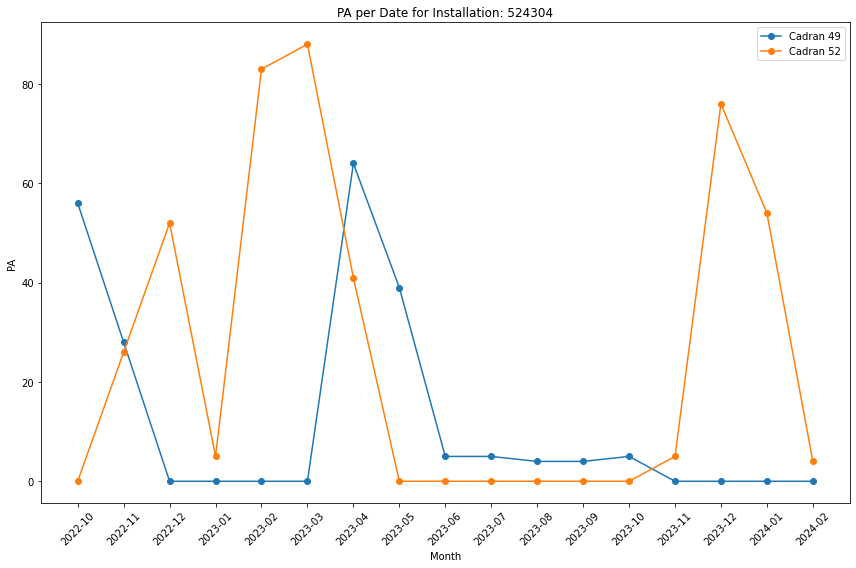

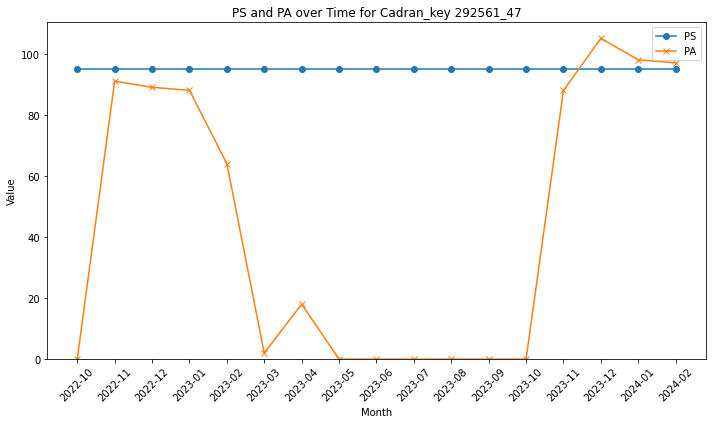

In [15]:
def plot_PA_per_date_for_installation(df, installation,saveName=""):
    filtered_df = df[df['Installation'] == installation]
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Numero_Cadran_PA'].unique()
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Numero_Cadran_PA'] == cadran]
        plt.plot(subset_df['month'], subset_df['PA'], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'PA per Date for Installation: {installation}')
    plt.xlabel('Month')
    plt.ylabel('PA')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()


plot_PA_per_date_for_installation(pa_df,524304)

def plot_PA_AND_PS_per_date_for_Cadran(df, cadran_key):
    cadran_key = str(cadran_key)
    specific_cadran_df = df[df['Cadran_key'] == cadran_key]
    plt.figure(figsize=(10, 6))
    plt.plot(specific_cadran_df['month'], specific_cadran_df['PS'], label='PS', marker='o')  # PS line
    plt.plot(specific_cadran_df['month'], specific_cadran_df['PA'], label='PA', marker='x')  # PA line
    plt.ylim(bottom=0) 
    # Formatting the plot
    plt.title(f'PS and PA over Time for Cadran_key {cadran_key}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.legend() 
    plt.tight_layout()
    plt.show()


plot_PA_AND_PS_per_date_for_Cadran(pa_df,'292561_47')
    


def print_Date_de_Releve_for_Cadran_key(df, specific_cadran_key):
    filtered_df = df[df['Cadran_key'] == specific_cadran_key]
    print(filtered_df['Date_de_releve'])
    
#print_Date_de_Releve_for_Cadran_key(consolidated_df,'41036856101_1')


    


# Clustering

## Agregation per Installation/Month and instertion maxPA/MaxPS

In [16]:
def get_aggregated_data_per_month(regenerate = False):
    export_path = os.path.join(folder_path,data_paths['combined_data_month'])
    print("get_aggregated_data_per_month from "+export_path)
    columns_to_drop=['']
    #dtype_spec = {'PS': 'string','PA':'string','Nom_Cadran_PA':'string'}
    
    def export():
        df = get_pa_data()
        print(df.columns)
        print("export")
        column_name_mapping = {
        }
        
        aggregated = df.groupby(['Installation', 'month']).agg(
            maxPA=('PA', 'max'),
            maxPS=('PS', 'max'),
            Code_NAF=('Code_NAF', 'first'),  # Takes the first occurrence
            REGION=('REGION', 'first') 
        ).reset_index()

        print(aggregated.head())
        print(aggregated.dtypes)
        aggregated['maxPA']=aggregated['maxPA'].astype('float')
        aggregated['maxPS']=aggregated['maxPS'].astype('float')
        print(aggregated.dtypes)
        aggregated['maxPA/maxPS']=aggregated['maxPA']/aggregated['maxPS']
        dataframe_to_csv(aggregated, data_paths['combined_data_month'])
        return aggregated
        
    if os.path.isfile(export_path) and not regenerate:
        aggregated = pd.read_csv(export_path,low_memory=False)
        aggregated = drop_columns(aggregated,columns_to_drop)
    else:
        aggregated = export()
    
    return aggregated

aggregated_df_per_month = get_aggregated_data_per_month()
print(f'nb Installation x months is {len(aggregated_df_per_month)}')

merged=pd.merge(aggregated_df_per_month, found_anomalies, on=['Installation','month'], how='left')
dataframe_to_csv(merged, data_paths['aggregated_df_per_month_merged_with_ano'])

def get_ANO_per_Installation(installation):
    filtered_df = merged[merged['Installation']==installation & merged['Num_ANO'].notna()]
    grouped = filtered_df.groupby('month')['Num_ANO'].agg(list).reset_index()
    # Convert grouped data to dictionary {month: list of Num_ANO}
    result_dict = dict(zip(grouped['month'], grouped['Num_ANO']))
    return result_dict

print(merged_df.columns)
print(merged_df.head())



get_aggregated_data_per_month from /Users/michaelargi/projects/perso/unsupervised/2024_04_12/combined_data_month.csv
nb Installation x months is 2029155
Index(['Installation', 'Numero_Cadran_PA', 'Cadran_key', 'Date_de_releve',
       'month', 'PA', 'PS', 'Num_ANO', 'Num_Cadran'],
      dtype='object')
   Installation  Numero_Cadran_PA Cadran_key Date_de_releve    month    PA  \
0        292561                47  292561_47     2022-10-11  2022-10  0.00   
1        292561                47  292561_47     2022-11-11  2022-11 91.00   
2        292561                47  292561_47     2022-12-11  2022-12 89.00   
3        292561                47  292561_47     2023-01-11  2023-01 88.00   
4        292561                47  292561_47     2023-02-11  2023-02 64.00   

     PS  Num_ANO  Num_Cadran  
0 95.00      NaN         NaN  
1 95.00      NaN         NaN  
2 95.00      NaN         NaN  
3 95.00      NaN         NaN  
4 95.00      NaN         NaN  


## Creating a pivot table with Installation as index and months as columns

In [17]:
# like a pivot table in XL=> month in columns 
pivot_df = aggregated_df_per_month.pivot(index='Installation', columns='month', values='maxPA/maxPS')
print(pivot_df.columns)
print(f'nb Lines {len(pivot_df)}')

Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
nb Lines 123667


## Detele all rows where at least one value >1 (PA>PS)

In [18]:
if ENV.delete_rows_PA_SUP_PS:
    mask = (pivot_df > 1).any(axis=1)
    pivot_df = pivot_df[~mask]
    print(f'nb Lines {len(pivot_df)}')

## Filtering Installation with data for all months

In [19]:
pivot_df_with_all_months = pivot_df.dropna().copy()

#print(pivot_df_with_all_months)
print(len(pivot_df_with_all_months))

83366


## Let's clusterize these Installations with data for all months 

clusterizing with 150
[39, 76, 97, 102, 131, 137, 138, 145]
nb centroids 142
Cluster 131: 1 Installations
Cluster 97: 1 Installations
Cluster 137: 1 Installations
Cluster 39: 1 Installations
Cluster 76: 1 Installations
Cluster 145: 1 Installations
Cluster 138: 2 Installations
Cluster 102: 2 Installations
Cluster 147: 7 Installations
Cluster 142: 20 Installations
Cluster 25: 24 Installations
Cluster 133: 34 Installations
Cluster 84: 37 Installations
Cluster 21: 51 Installations
Cluster 54: 52 Installations
Cluster 33: 53 Installations
Cluster 37: 55 Installations
Cluster 67: 58 Installations
Cluster 81: 60 Installations
Cluster 43: 67 Installations
Cluster 17: 68 Installations
Cluster 94: 70 Installations
Cluster 99: 71 Installations
Cluster 98: 71 Installations
Cluster 121: 72 Installations
Cluster 119: 73 Installations
Cluster 109: 74 Installations
Cluster 27: 76 Installations
Cluster 16: 79 Installations
Cluster 26: 79 Installations
Cluster 146: 81 Installations
Cluster 59: 86 Instal

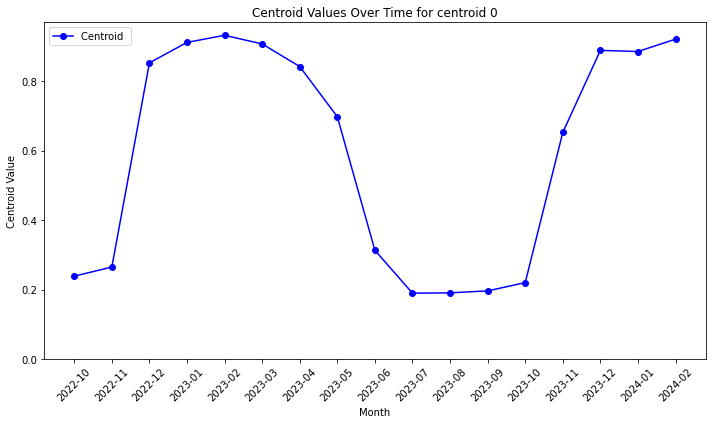

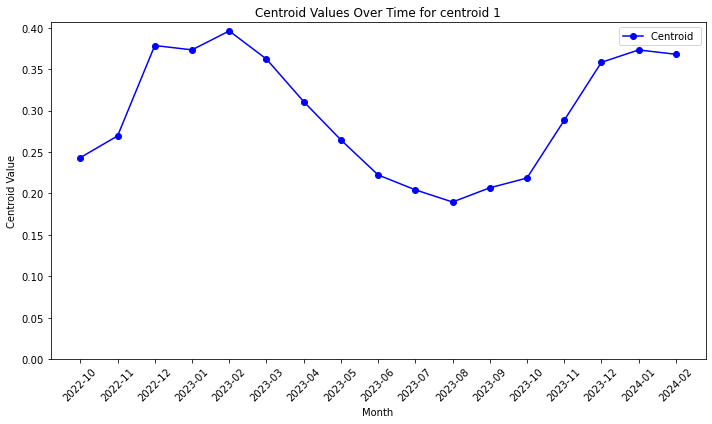

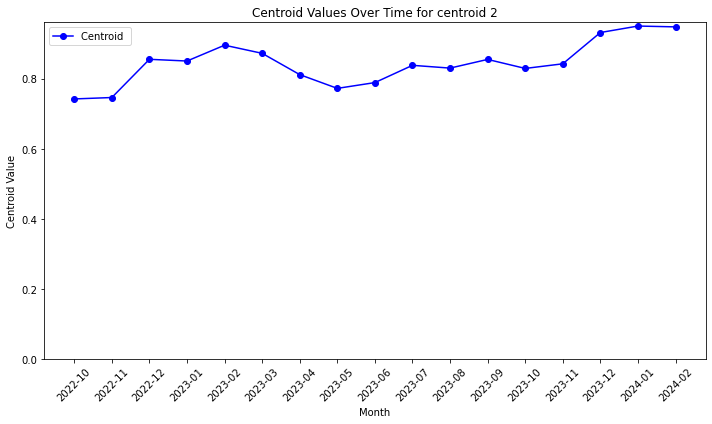

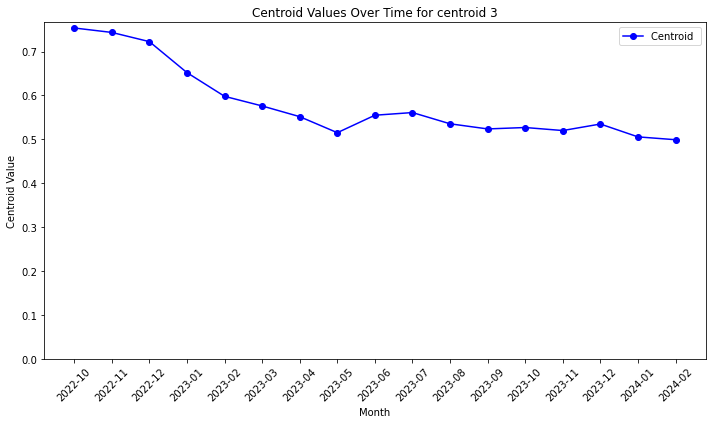

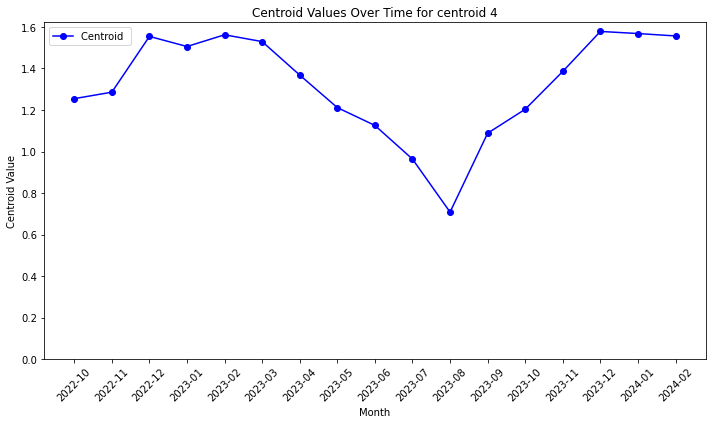

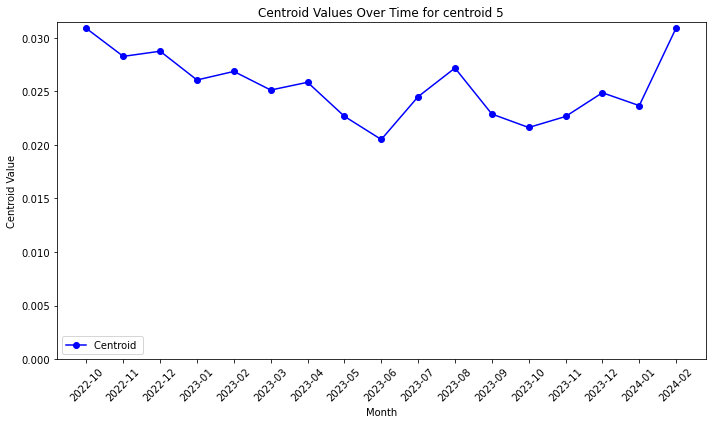

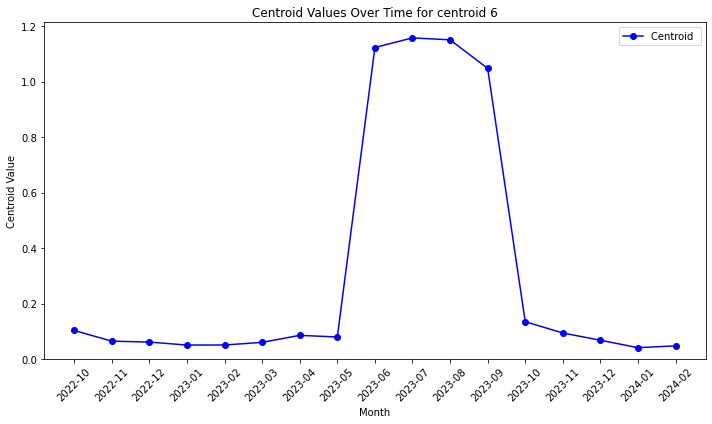

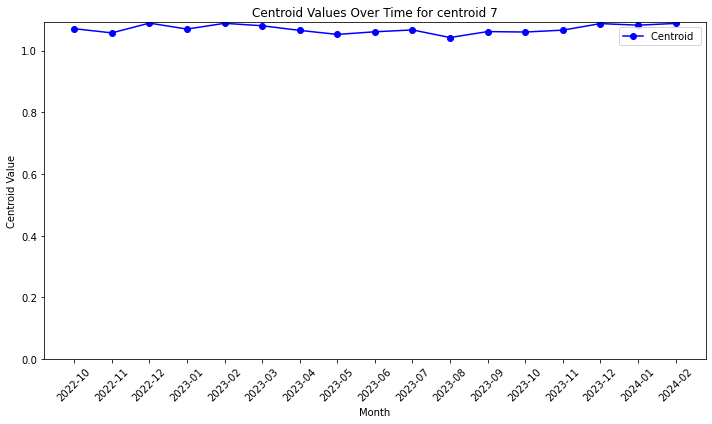

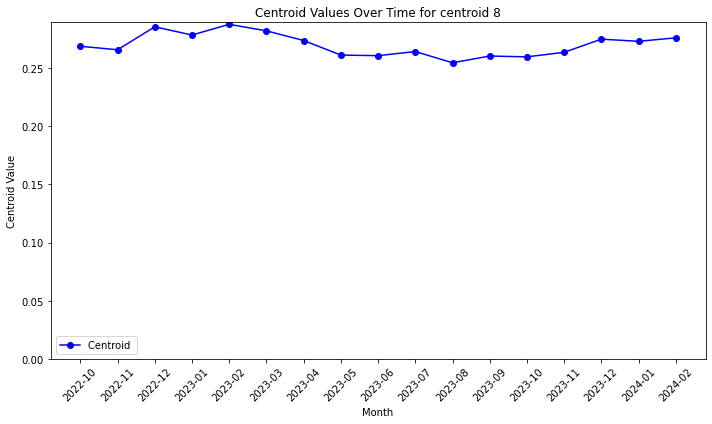

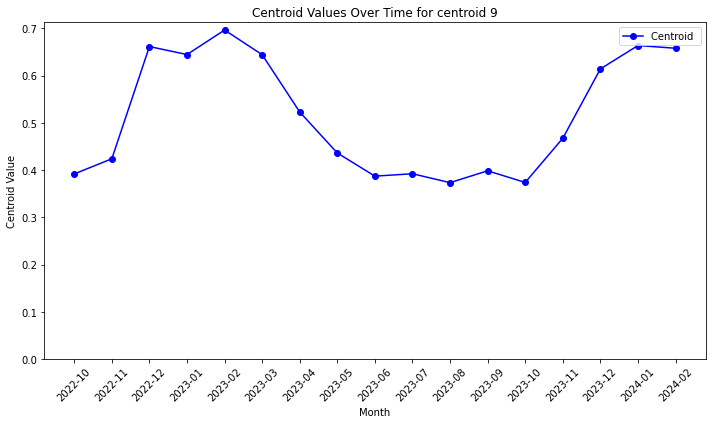

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

nb_clusters= ENV.max_nb_clusters

def plot_centroid(id,months,centroids_original_scale):
    values = centroids_original_scale[id]
    plt.figure(figsize=(10, 6))
    plt.plot(months, values, label='Centroid ', marker='o', linestyle='-', color='blue')
    
    # Formatting the plot
    plt.title(f'Centroid Values Over Time for centroid {id}')
    plt.ylim(bottom=0) 
    plt.xlabel('Month')
    plt.ylabel('Centroid Value')
    plt.xticks(months, labels=months, rotation=45)  # Set x-ticks labels explicitly if needed
    plt.legend()

    plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
    plt.show()
    
scaler = StandardScaler()

def clusterize(pivot_df_with_all_months, nb_clusters, min_size):
    print(f"clusterizing with {nb_clusters}")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pivot_df_with_all_months)
    kmeans = KMeans(n_clusters=nb_clusters,random_state=42)
    kmeans.fit(scaled_features)  # Ensure you fit the scaled features
    
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))

    # Identify clusters with only one item
    small_clusters = [cluster_id for cluster_id, size in cluster_sizes.items() if size < min_size]
    print(small_clusters)
    # Filter out centroids of these small clusters
    centroids = kmeans.cluster_centers_
    filtered_centroids = np.array([centroids[i] for i in range(len(centroids)) if i not in small_clusters])
    
    return scaler,kmeans,filtered_centroids

min_nb_in_cluster = 0

''' Idea was finding the best nb of clusters 
while min_nb_in_cluster<ENV.min_nb_in_cluster:
    scaler, kmeans_=clusterize(pivot_df_with_all_months, nb_clusters)
    kmeans_labels_ = kmeans_.labels_
    cluster_counts = Counter(kmeans_labels_)
    sorted_cluster_counts = sorted(cluster_counts.items(), key=lambda item: item[1])
    print(sorted_cluster_counts[0])
    index, min_nb_in_cluster = sorted_cluster_counts[0]
    print(f'min_nb_in_cluster is {min_nb_in_cluster}')
    nb_clusters-=10
'''
# I decided to take arbitrary number and drop the "singles"
scaler, kmeans_,filtered_centroids=clusterize(pivot_df_with_all_months, nb_clusters,3)
kmeans_labels_ = kmeans_.labels_
print(f'nb centroids {len(filtered_centroids)}')

# Identify single-item clusters
cluster_counts = Counter(kmeans_labels_)
sorted_cluster_counts = sorted(cluster_counts.items(), key=lambda item: item[1])

centroids_original_scale = scaler.inverse_transform(kmeans_.cluster_centers_)

np.save('centroids_original_scale.npy', centroids_original_scale)
                
exclude_columns = ['cluster', 'MaxDistColumn', 'SignedMaxDistance', 'MaxDistance']
filtered_columns = [col for col in pivot_df_with_all_months.columns if col not in exclude_columns]


# Printing sorted counts
for cluster_id, count in sorted_cluster_counts:
    print(f"Cluster {cluster_id}: {count} Installations")
    
for i in range(0,min(len(centroids_original_scale),10)):
    plot_centroid(i,filtered_columns,centroids_original_scale)



## Then assign all Installations to clusters

In [23]:

# Assuming centroids_original_scale contains the centroids in their original scale
print("assigning all Installations to found cluster")

pivot_df = drop_columns(pivot_df,['cluster'])

def squared_distance_to_centroid(row, centroid):
    # Calculate the sum of absolute differences, ignoring NaN values
    valid_indices = ~np.isnan(row)
    squared_differences = (row[valid_indices] - centroid[valid_indices]) ** 2
    #abs_differences = np.sum(np.abs(row[valid_indices] - centroid[valid_indices]))
    return np.sum(squared_differences)


# we take the sum of distances (squared) of each row point to its neighbouring (-1,0,+1) centroid points.
#Beware, centroid values are between 0 and 1. so taking x as month index is a mistake, hence the x_factor. 

def squared_distance_to_centroid_x_y(row, centroid):
    row = np.array(row)
    centroid = np.array(centroid)
    x_factor = 0.1
    valid_indices = ~np.isnan(row) #& ~np.isnan(centroid)

    total_min_distance = 0

    # Calculate distances from each valid row point to -1/+1 month centroid's points
    for index in np.where(valid_indices)[0]:
        row_value=row[index]
        # Creating the point (x, y) for the row where x is the index and y is the value
        row_point = np.array([index*x_factor, row_value])
        distances = []
        min_distance_to_one_point = float('inf')
        for c_index in range(max(0,index-1), min(index+2,len(centroid))):
            centroid_value = centroid[c_index]
            centroid_point = np.array([c_index*x_factor, centroid_value])
            
            # Euclidean distance calculation
            distance = np.linalg.norm(row_point - centroid_point)
            squared_distance = (row_point[0] - centroid_point[0])**2 + (row_point[1] - centroid_point[1])**2
            #min_distance_to_one_point= min(min_distance_to_one_point,distance)
        
        total_min_distance+=squared_distance#min_distance_to_one_point
    
    return total_min_distance

# Initialize a list to hold the cluster assignments
cluster_assignments = []
cluster_distances = []

nb_rows = len(pivot_df)
index=0

USE_X_Y_DISTANCE = False

used_distance = squared_distance_to_centroid

if USE_X_Y_DISTANCE is True:
    used_distance=squared_distance_to_centroid_x_y
    
# Iterate over each row in pivot_df
for _, row in pivot_df.iterrows():
    row_values = row.values  # Convert the row to a NumPy array for easier element-wise operations
    min_distance = float('inf')
    cluster = -1
    cluster_index = 0
    index +=1
    #if index%1000 ==0:
    #    print(f"index {index} out of {nb_rows}")
    
    # Iterate over each centroid to find the closest one
    for centroid in centroids_original_scale:
        distance = used_distance(row_values, centroid)
        if distance < min_distance:
            min_distance = distance
            cluster = cluster_index
        cluster_index += 1
    
    # Assign the closest cluster to the row
    cluster_distances.append(min_distance)
    cluster_assignments.append(cluster)

# Assign the cluster assignments back to the DataFrame
pivot_df['cluster'] = cluster_assignments
pivot_df['distance_to_cluster'] = cluster_distances

cluster_df = pivot_df.reset_index()
cluster_df = cluster_df[['Installation', 'cluster']]

dataframe_to_csv(cluster_df, data_paths['installation_cluster'])

def get_installations_in_cluster(cluster_id):
    return cluster_df[cluster_df['cluster']==cluster_id]


    
print(pivot_df.head())


assigning all Installations to found cluster
month         2022-10  2022-11  2022-12  2023-01  2023-02  2023-03  2023-04  \
Installation                                                                  
292561           1.00     0.96     0.94     0.93     0.67     0.02     0.40   
292562           0.67     0.77     0.73     0.85     0.92     0.60     0.69   
292563           0.83     0.80     0.73     0.73     0.00     0.66     0.53   
292564           0.18     0.17     0.34     0.66     0.83     0.88     0.78   
292567           0.41     0.25     0.53     0.31     0.12     0.52     0.27   

month         2023-05  2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  \
Installation                                                                  
292561           1.14     1.00     0.82     0.93     0.91     0.99     1.11   
292562           0.73     0.52     0.65     0.56     0.60     0.75     0.88   
292563           0.56     0.63     0.60     0.63     0.59     0.56     0.50   
292564

In [24]:
def most_common_value_and_share(series):
    # Count frequencies of each value in the column
    value_counts = series.value_counts(normalize=True)
    
    # Get the most common value and its frequency
    most_common = value_counts.idxmax()
    most_common_share = value_counts.max()
    
    # Format the share as a percentage
    most_common_share_percentage = "{:.2%}".format(most_common_share)
    
    return most_common, most_common_share_percentage

def top_5_common_values_and_shares(series):
    value_counts = series.value_counts(normalize=True)
    top_5 = value_counts.head(5)
    top_5_percentage = top_5.apply(lambda x: "{:.2%}".format(x))
    result_df = pd.DataFrame({
        'Value': top_5.index,
        'Share': top_5_percentage
    }).reset_index(drop=True)
    
    return result_df

def get_information_from_cluster(pa_df,cluster_id):
    filter = get_installations_in_cluster(cluster_id)
    installations = filter['Installation'].unique()
    print(len(installations))
    df = pa_df[pa_df['Installation'].isin(installations)]
    df['Reduced_NAF'] = df['Code_NAF'].str.slice(0, 5)
    nb_NAF = df['Reduced_NAF'].nunique()
    nb_REGION = df['REGION'].nunique()
    
    code_naf_common = top_5_common_values_and_shares(df['Reduced_NAF'])
    print (code_naf_common)
    print(f" out of {nb_NAF} NAF Values in cluster")
    region_common = top_5_common_values_and_shares(df['REGION'])
    print(region_common)
    print(f"out of {nb_REGION} REGIONs Values in cluster")

get_information_from_cluster(aggregated_df_per_month,42)

665
   Value   Share
0  8411Z  15.99%
1  0146Z   5.22%
2  4511Z   4.24%
3  8710A   4.23%
4  7010Z   4.10%
 out of 191 NAF Values in cluster
  Value  Share
0    93  3.89%
1   252  3.56%
2   152  2.61%
3   145  2.60%
4   144  2.57%
out of 107 REGIONs Values in cluster


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_38777/1913571996.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Reduced_NAF'] = df['Code_NAF'].str.slice(0, 5)


# Find outliers

In [25]:
print("looking four outliers")
pivot_df['cluster'] = pivot_df['cluster'].astype(int)
#print(pivot_df.dtypes)
#print(centroids_original_scale)
def calculate_distances_old(row):
    cluster = int(row['cluster'])
    
    # Retrieve the centroid for the assigned cluster
    centroid = centroids_original_scale[cluster]
    # Calculate the differences for all columns (ignoring NaN in original data)
    distances = row.values[:-1] - centroid  # Exclude the cluster label from row values
    
    # Find the index of the maximum absolute distance
    max_abs_distance_index = np.argmax(np.abs(distances))
    # Use this index to find the signed maximum distance
    signed_max_distance = distances[max_abs_distance_index]
    if np.isnan(signed_max_distance):
        print(row)
    
    # Get the column name corresponding to the maximum (absolute) distance
    max_distance_column = pivot_df.columns[max_abs_distance_index]
    
    return pd.Series([max_distance_column, signed_max_distance], index=['MaxDistColumn', 'SignedMaxDistance'])

def calculate_distances(row, centroids_original_scale, pivot_df):
    cluster = int(row['cluster'])
    centroid = centroids_original_scale[cluster]

    
    # Exclude the cluster label from row values and ensure dimensions match
    values = row.drop('cluster')  # Directly drop 'cluster' to avoid dimensional mismatch
    
    # Check if centroids have valid data
    if np.any(np.isnan(centroid)):
        print("Centroid contains NaN values which may cause errors in distance calculations.")
    
    # Compute valid indices for non-NaN values
    valid_indices = ~np.isnan(values)
    valid_indices["cluster"]=False
    
    centroid= np.append(centroid,[0])
    # Ensure valid_indices and centroid have matching dimensions
    valid_centroid = centroid[valid_indices]
    valid_values = values[valid_indices]
    
    if valid_values.size > 0:
        distances = valid_values - valid_centroid
        max_abs_distance_index = np.argmax(np.abs(distances))
        signed_max_distance = distances[max_abs_distance_index]
        
        # Properly access the column names using valid indices
        valid_columns = pivot_df.columns[valid_indices]
        max_distance_column = valid_columns[max_abs_distance_index]
    else:
        max_distance_column = 'None'
        signed_max_distance = np.nan
        print("All values are NaN or centroid is not defined.")
    
    return pd.Series([max_distance_column, signed_max_distance], index=['MaxDistColumn', 'SignedMaxDistance'])
    
print("firing")
#reset in case we restart not from scratch
columns_to_delete = ['MaxDistColumn','SignedMaxDistance','MaxDistance','distance_to_cluster']
pivot_df = drop_columns(pivot_df,columns_to_delete)

# Apply the modified function to each row and assign the results to new columns
pivot_df[['MaxDistColumn', 'SignedMaxDistance']] = pivot_df.apply(lambda row: calculate_distances(row, centroids_original_scale, pivot_df), axis=1)
pivot_df['MaxDistance'] = pivot_df['SignedMaxDistance'].abs()

# Now, sort pivot_df by 'MaxDistance' in descending order to see the most anomalous entries first
pivot_df_sorted = pivot_df.sort_values(by='MaxDistance', ascending=False)



pivot_to_csv(pivot_df_sorted, data_paths['pivot_ouliers'])



#only the ones with PA > centroid
pivot_df_sorted_and_filtered_UP = pivot_df_sorted[pivot_df_sorted['SignedMaxDistance']>0]
#only the ones with PA > centroid
pivot_df_sorted_and_filtered = pivot_df_sorted[pivot_df_sorted['SignedMaxDistance']<0]

print(pivot_df_sorted_and_filtered_UP.head())
#print(pivot_df_sorted_and_filtered.head())


looking four outliers
firing
month         2022-10  2022-11  2022-12  2023-01  2023-02  2023-03  2023-04  \
Installation                                                                  
445052            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
450760          19.00      NaN    16.55      NaN    16.75    16.85      NaN   
489318           0.10     0.30     0.30     0.30     1.80    16.30     1.10   
459351           0.33     0.56      NaN     0.54     0.49     0.42     0.47   
295956           9.37     9.69     9.69     9.69    10.43    10.43     9.55   

month         2023-05  2023-06  2023-07  ...  2023-09  2023-10  2023-11  \
Installation                             ...                              
445052            inf      inf      inf  ...      NaN      NaN      NaN   
450760           0.00     0.00     0.00  ...     0.00     0.85     0.00   
489318           0.60     2.40     0.60  ...     5.10    12.80     3.60   
459351           0.40     0.33     0.47  .

Found anomalies  {}
Installation     497624
month           2022-10
maxPA              0.00
maxPS              5.00
Code_NAF          3511Z
REGION              191
maxPA/maxPS        0.00
Name: 1808026, dtype: object
Displaying Installation 497624 for month 2024-02 in cluster 131


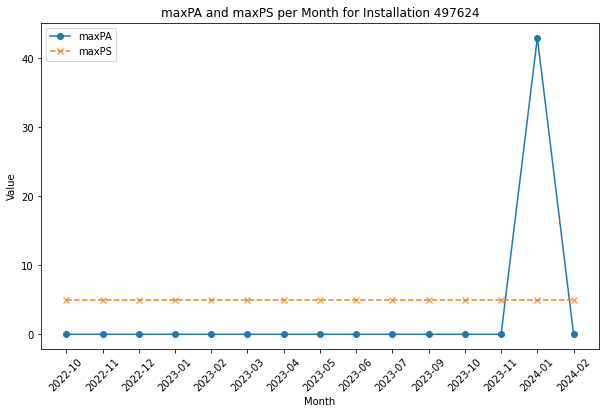

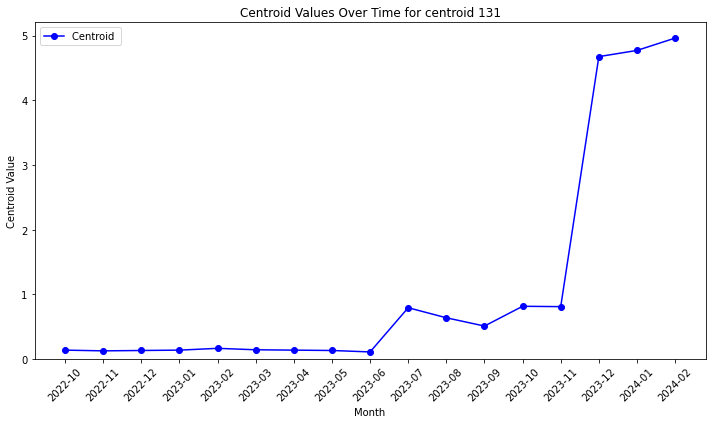

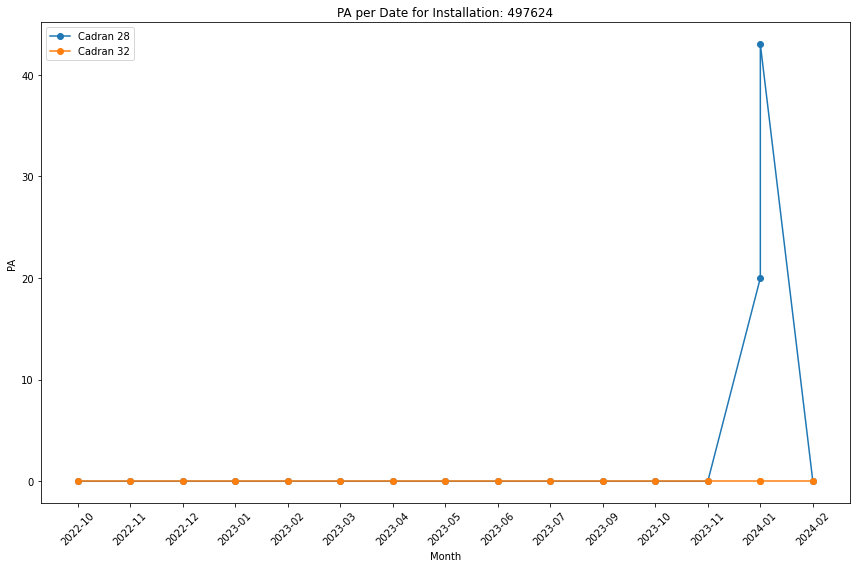

Found anomalies  {}
Installation     494991
month           2022-10
maxPA             57.00
maxPS             14.03
Code_NAF          0162Z
REGION              143
maxPA/maxPS        4.06
Name: 1782830, dtype: object
Displaying Installation 494991 for month 2023-01 in cluster 102


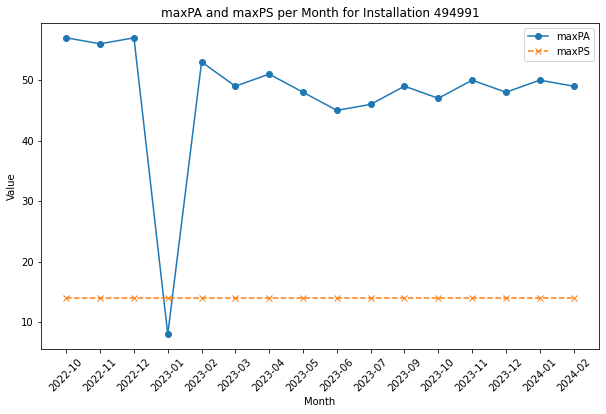

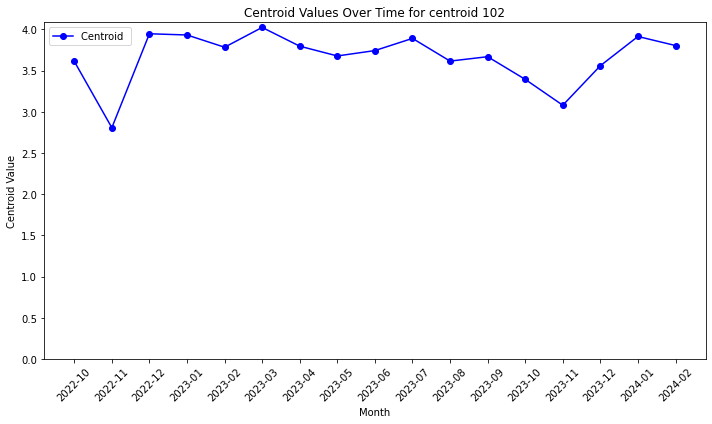

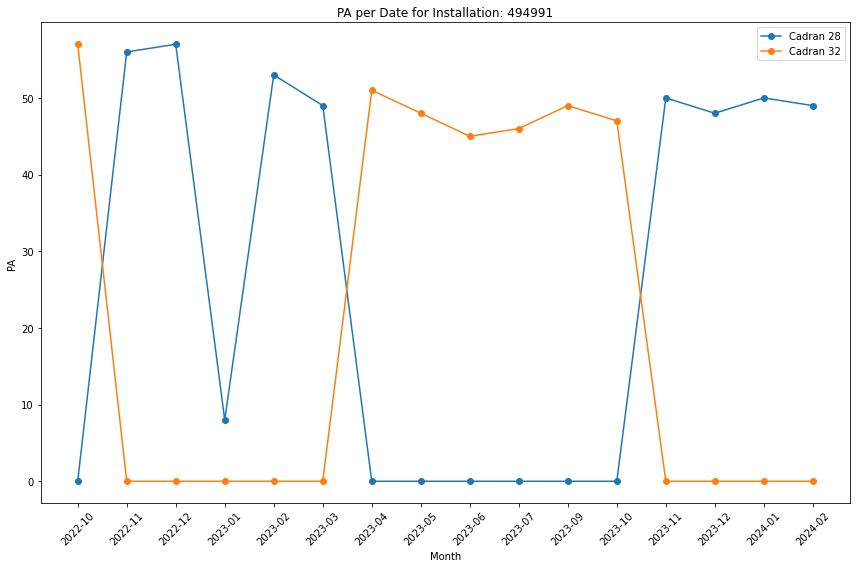

Found anomalies  {}
Installation     488160
month           2022-10
maxPA             17.00
maxPS              6.00
Code_NAF          0142Z
REGION               93
maxPA/maxPS        2.83
Name: 1723382, dtype: object
Displaying Installation 488160 for month 2024-01 in cluster 102


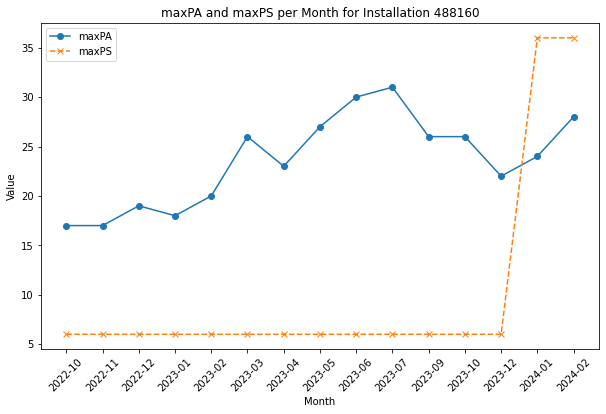

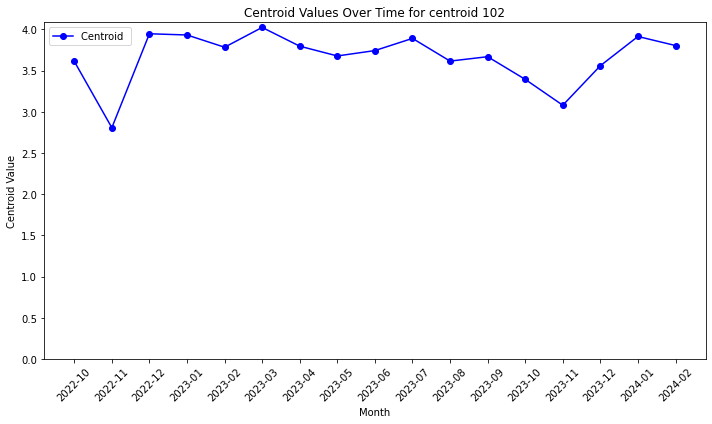

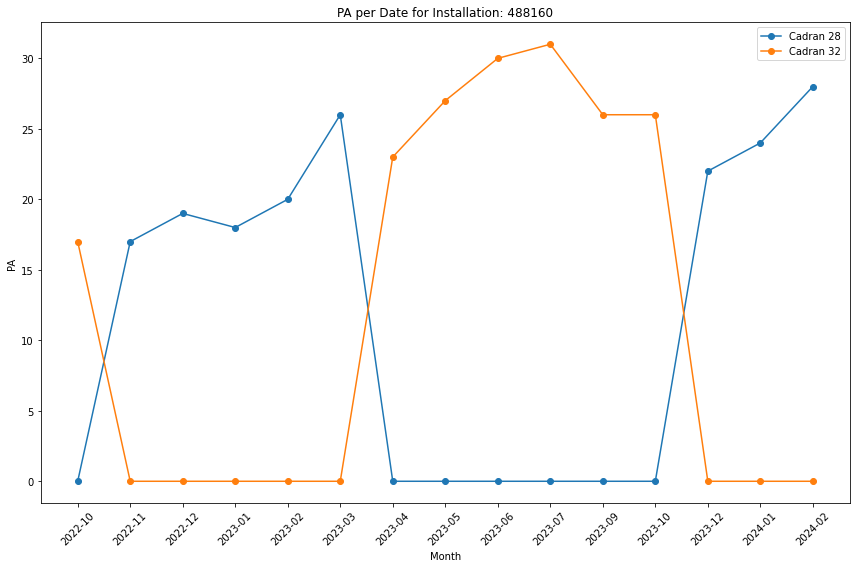

Found anomalies  {}
Installation     490217
month           2022-10
maxPA             18.00
maxPS             20.00
Code_NAF          8411Z
REGION              17A
maxPA/maxPS        0.90
Name: 1748270, dtype: object
Displaying Installation 490217 for month 2022-12 in cluster 138


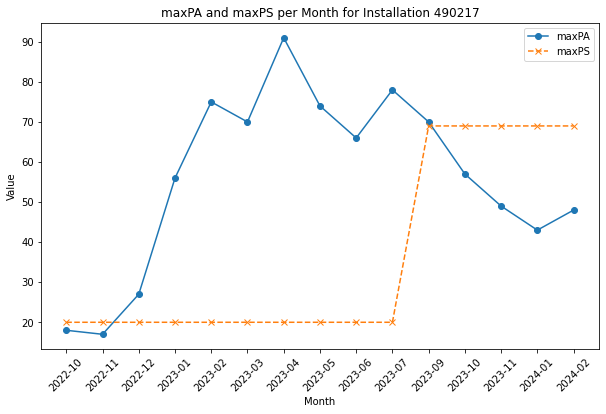

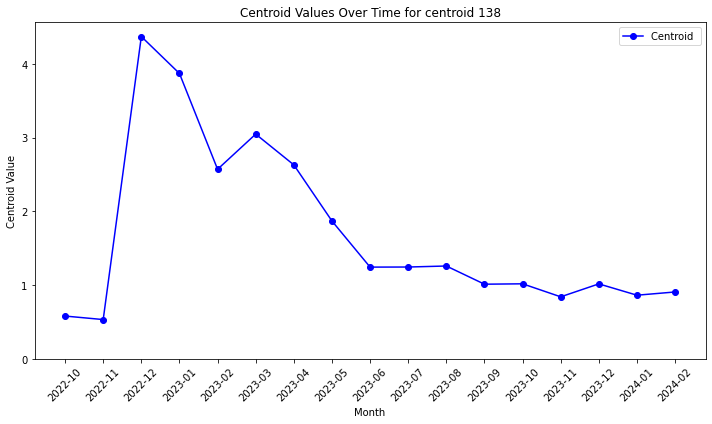

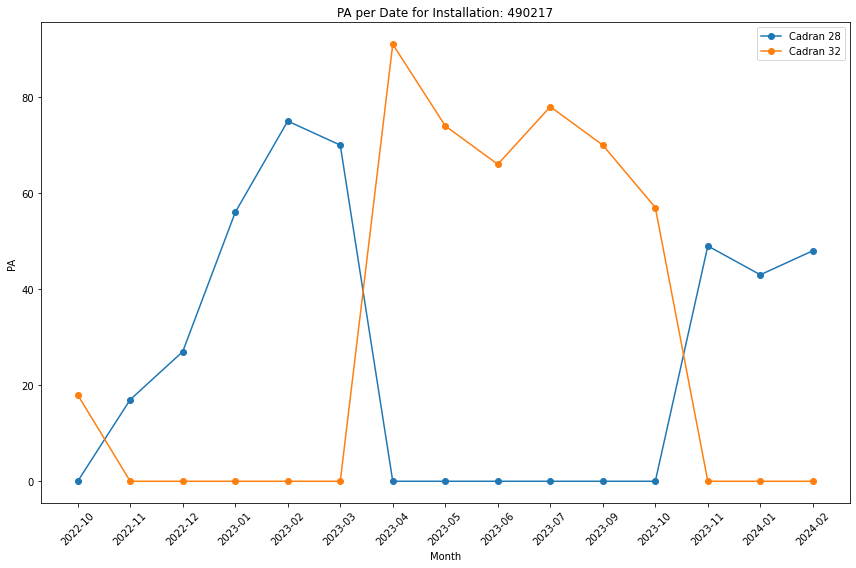

Found anomalies  {}
Installation     501388
month           2022-10
maxPA             95.00
maxPS             26.00
Code_NAF          8542Z
REGION               93
maxPA/maxPS        3.65
Name: 1843723, dtype: object
Displaying Installation 501388 for month 2023-07 in cluster 102


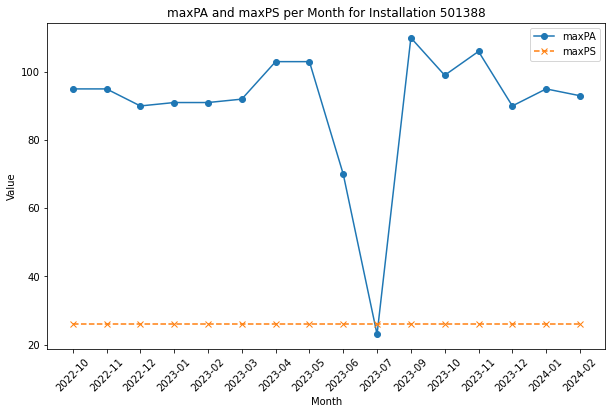

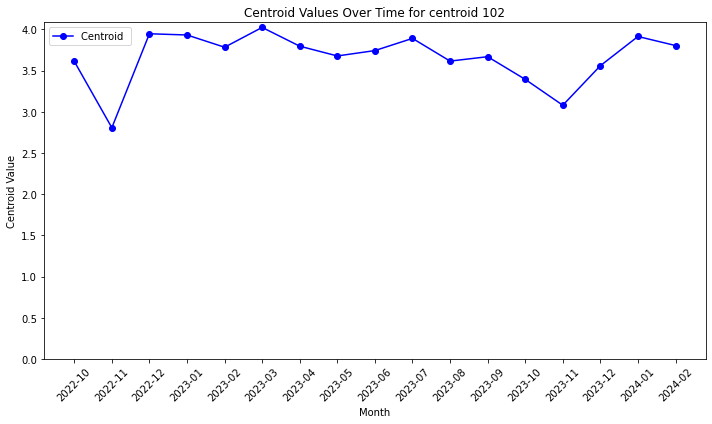

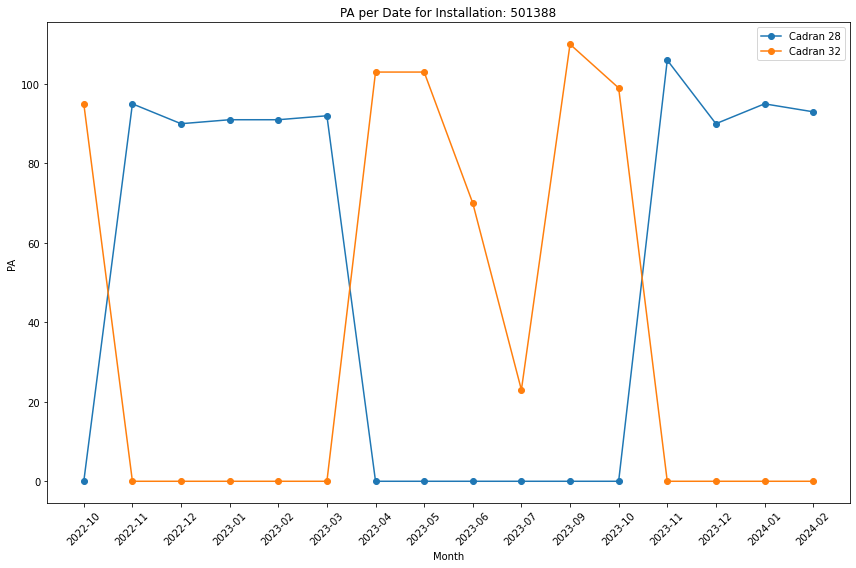

In [26]:
def plot_maxPA_maxPM_per_date_for_installation(df, installation,saveName=""):
    df_filtered = df[df['Installation'] == installation]
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['month'], df_filtered['maxPA'], marker='o', linestyle='-', label='maxPA')
    plt.plot(df_filtered['month'], df_filtered['maxPS'], marker='x', linestyle='--', label='maxPS')

    # Formatting the plot
    plt.title(f'maxPA and maxPS per Month for Installation {installation}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()
        

#print(pivot_df_sorted_and_filtered.head())

#print(centroids_original_scale)

exclude_columns = ['cluster', 'MaxDistColumn', 'SignedMaxDistance', 'MaxDistance']
filtered_columns = [col for col in pivot_df.columns if col not in exclude_columns]

first_five_installations = pivot_df_sorted_and_filtered.index[:5]

#print(pivot_df_sorted_and_filtered.head(2))

for installation in first_five_installations:
    print(f"Found anomalies  {get_ANO_per_Installation(installation)}")
    print(aggregated_df_per_month[aggregated_df_per_month["Installation"]== installation].iloc[0])
    installation_cluster = pivot_df_sorted_and_filtered.loc[installation, 'cluster']
    
    installation_month = pivot_df_sorted_and_filtered.loc[installation, 'MaxDistColumn']
    print(f'Displaying Installation {installation} for month {installation_month} in cluster {installation_cluster}')

    plot_maxPA_maxPM_per_date_for_installation(aggregated_df_per_month,installation)
    plot_centroid(installation_cluster,filtered_columns,centroids_original_scale)
    plot_PA_per_date_for_installation(pa_df,installation)


In [27]:

filtered_data = pa_df[(pa_df['Installation'] == 312378) & (pa_df['month'] == "2023-03")]

print(filtered_data)

        Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key  \
558653        312378    9102Z    07H                47  312378_47   
558670        312378    9102Z    07H                49  312378_49   

       Date_de_releve    month    PA    PS  
558653     2023-03-15  2023-03 87.00 42.00  
558670     2023-03-15  2023-03  0.00 42.00  


Displaying Installation 445052 for month 2023-05 in cluster -1
Installation     445052
month           2022-10
maxPA              0.00
maxPS              0.00
Code_NAF          0111Z
REGION              152
maxPA/maxPS         NaN
Name: 1385002, dtype: object


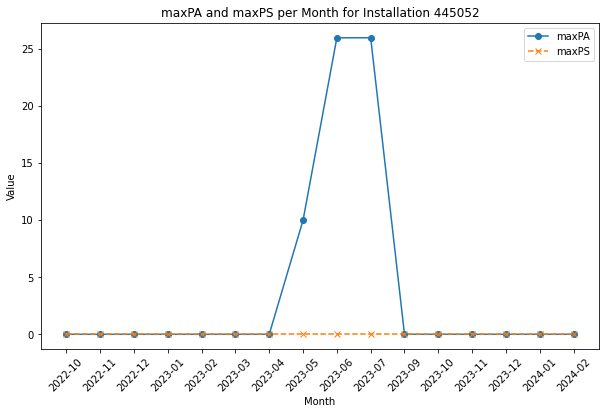

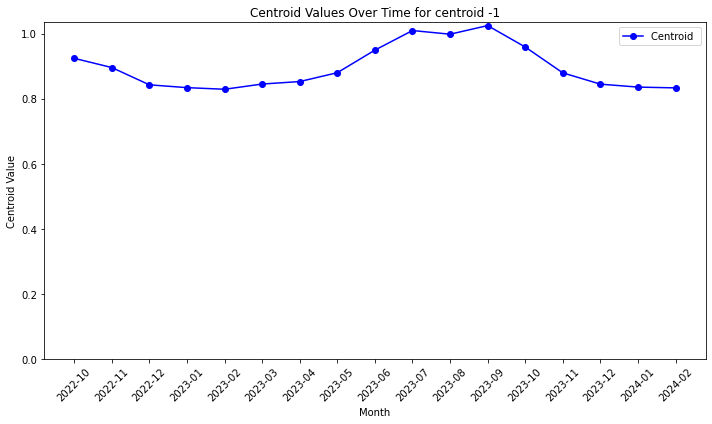

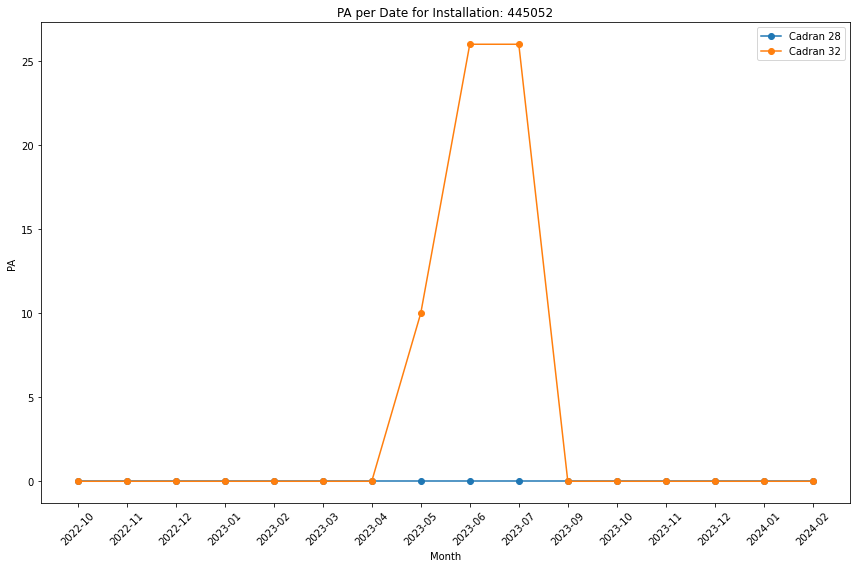

Displaying Installation 450760 for month 2022-10 in cluster 102
Installation     450760
month           2022-10
maxPA            380.00
maxPS             20.00
Code_NAF          3832Z
REGION               23
maxPA/maxPS       19.00
Name: 1429042, dtype: object


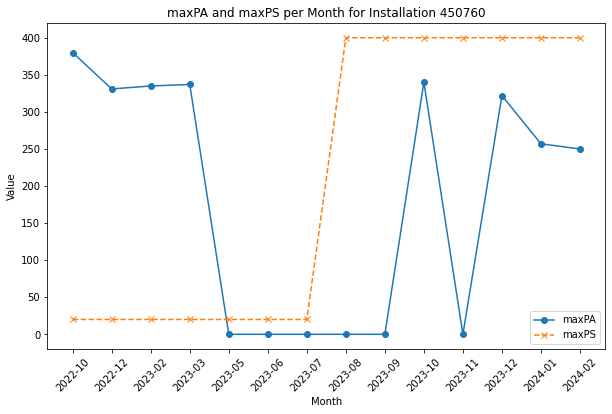

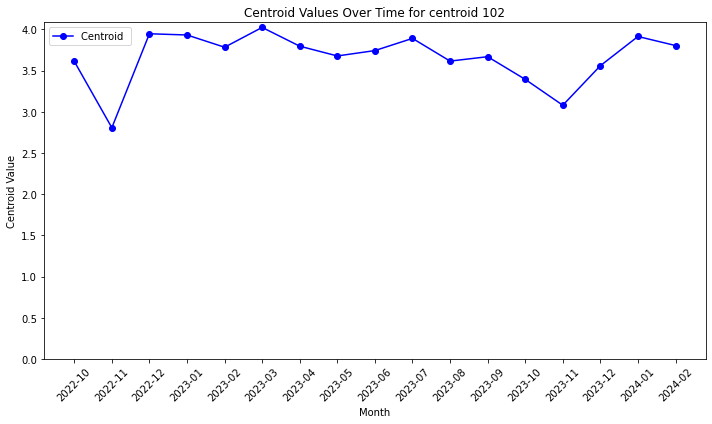

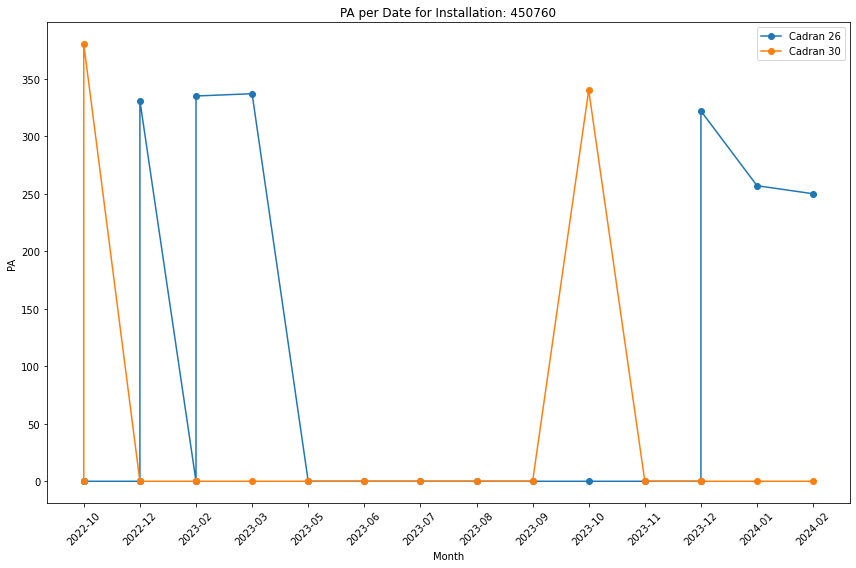

Displaying Installation 489318 for month 2023-03 in cluster 76
Installation     489318
month           2022-10
maxPA              1.00
maxPS             10.00
Code_NAF          3600Z
REGION              253
maxPA/maxPS        0.10
Name: 1737396, dtype: object


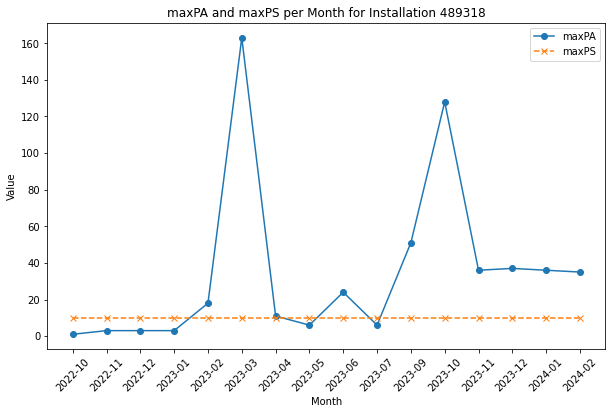

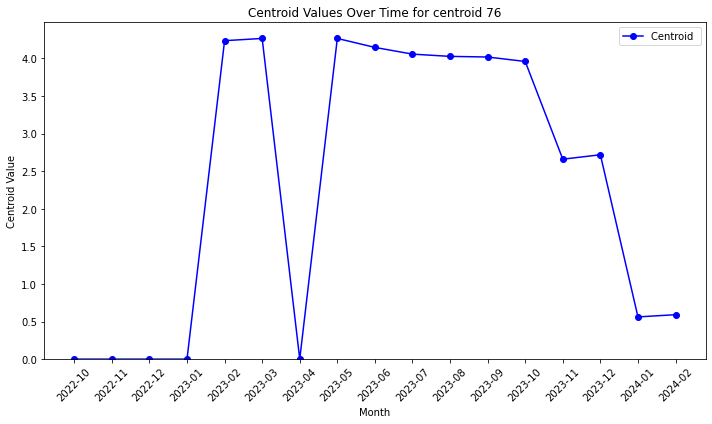

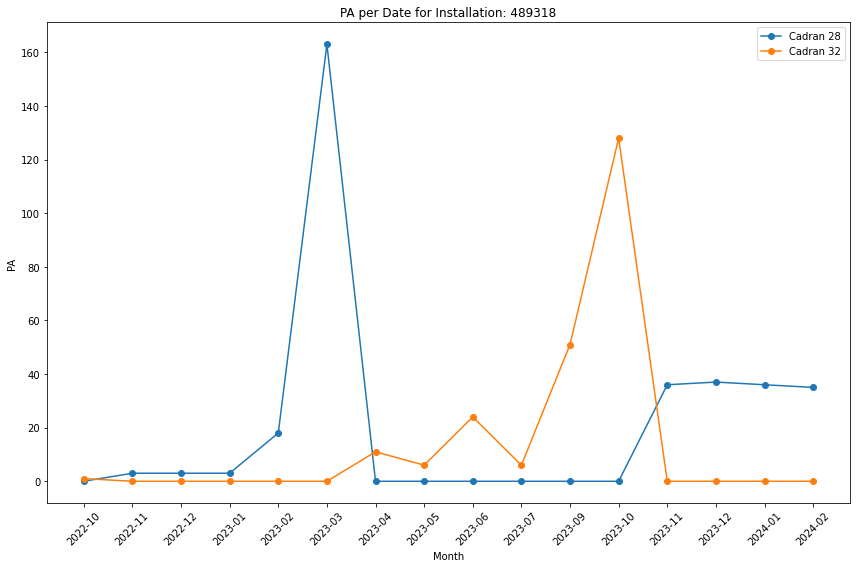

Displaying Installation 459351 for month 2023-09 in cluster 84
Installation     459351
month           2022-10
maxPA             32.00
maxPS             96.00
Code_NAF          1012Z
REGION              143
maxPA/maxPS        0.33
Name: 1496777, dtype: object


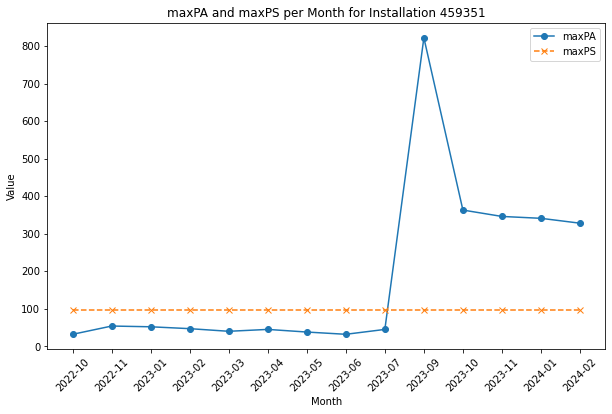

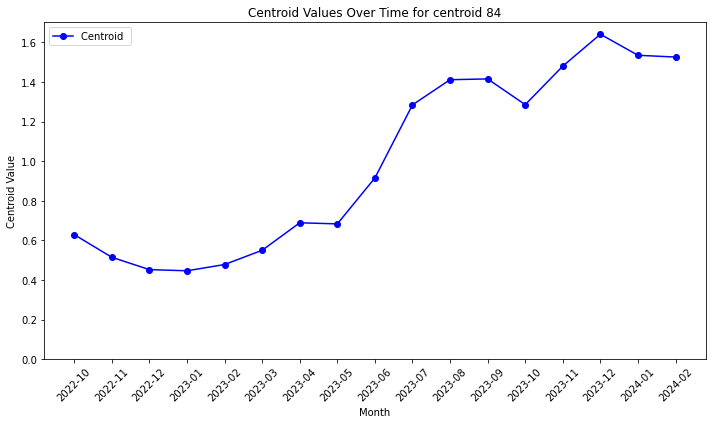

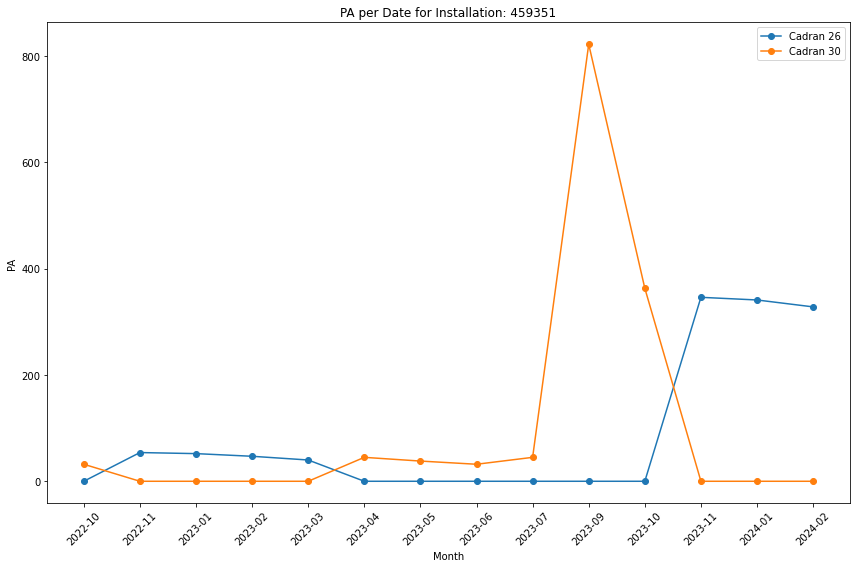

Displaying Installation 295956 for month 2022-11 in cluster 102
Installation     295956
month           2022-10
maxPA            203.00
maxPS             21.67
Code_NAF          5222Z
REGION              252
maxPA/maxPS        9.37
Name: 49148, dtype: object


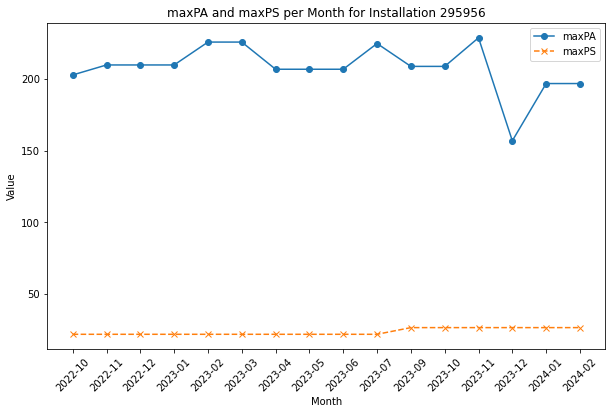

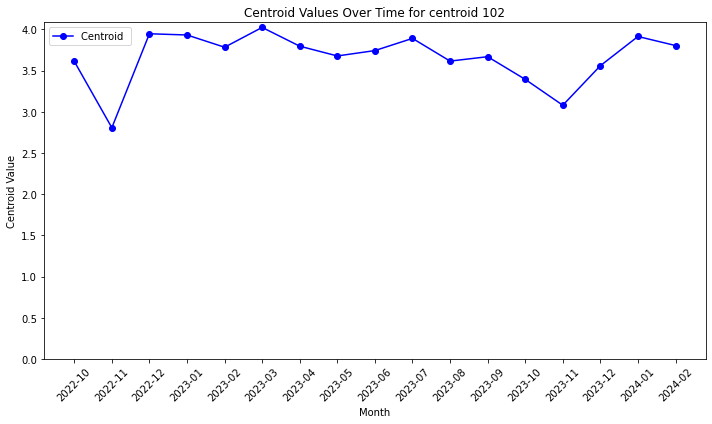

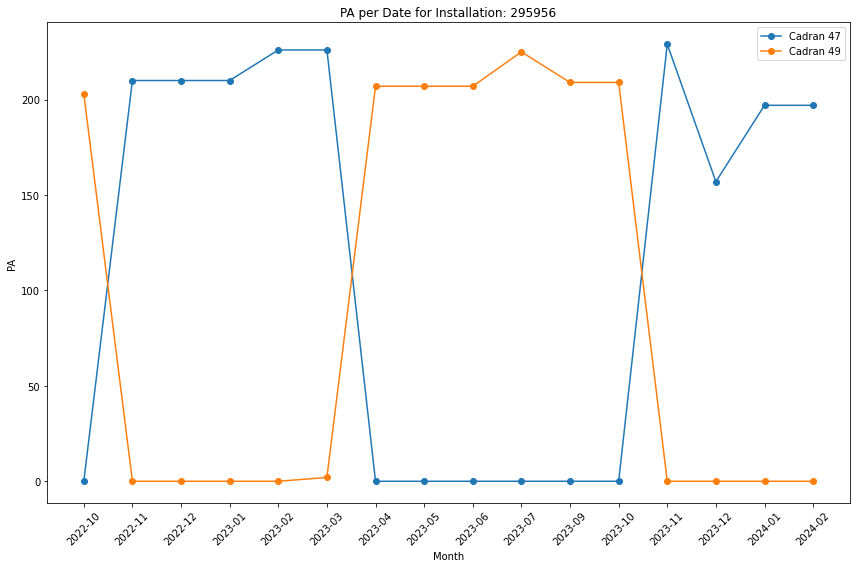

In [28]:
first_five_installations = pivot_df_sorted_and_filtered_UP.index[:5]

for installation in first_five_installations:
    installation_cluster = pivot_df_sorted_and_filtered_UP.loc[installation, 'cluster']
    installation_month = pivot_df_sorted_and_filtered_UP.loc[installation, 'MaxDistColumn']
    print(f'Displaying Installation {installation} for month {installation_month} in cluster {installation_cluster}')
    print(aggregated_df_per_month[aggregated_df_per_month["Installation"]== installation].iloc[0])
    plot_maxPA_maxPM_per_date_for_installation(aggregated_df_per_month,installation)
    plot_centroid(installation_cluster,filtered_columns,centroids_original_scale)
    plot_PA_per_date_for_installation(pa_df,installation)

month  Installation  cluster
18126        315462       21
21354        319321       21
23563        322017       21
23611        322080       21
25718        326282       21


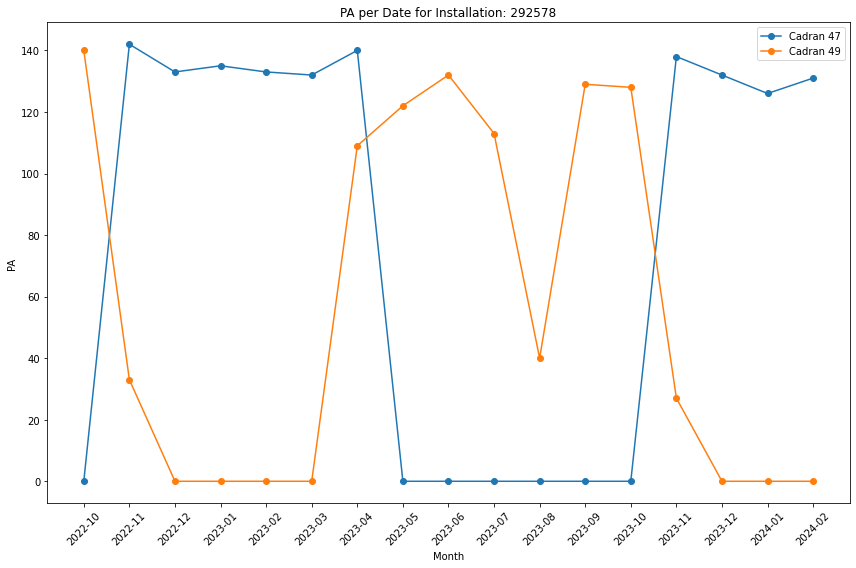

     Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key Date_de_releve  \
476        292578    8531Z     63                47  292578_47     2022-10-21   
477        292578    8531Z     63                47  292578_47     2022-11-20   
478        292578    8531Z     63                47  292578_47     2022-12-21   
479        292578    8531Z     63                47  292578_47     2023-01-21   
480        292578    8531Z     63                47  292578_47     2023-02-18   
481        292578    8531Z     63                47  292578_47     2023-03-21   
482        292578    8531Z     63                47  292578_47     2023-04-20   
483        292578    8531Z     63                47  292578_47     2023-05-21   
484        292578    8531Z     63                47  292578_47     2023-06-20   
485        292578    8531Z     63                47  292578_47     2023-07-21   
486        292578    8531Z     63                47  292578_47     2023-08-21   
487        292578    8531Z  

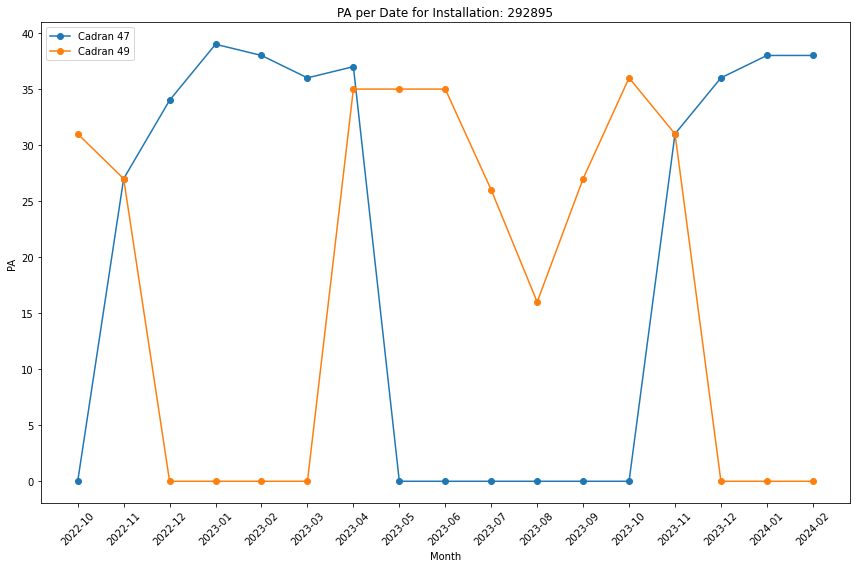

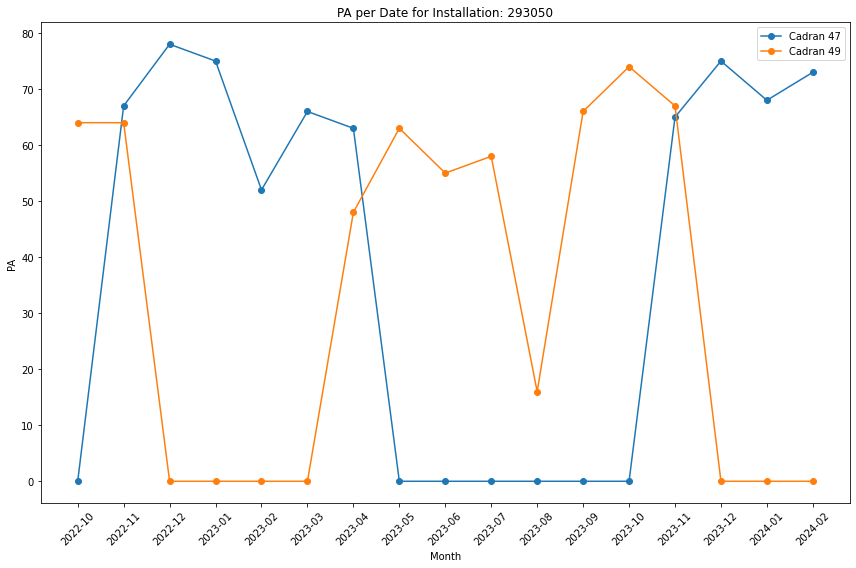

In [29]:
install = get_installations_in_cluster(21)
print(install.head(5))

plot_PA_per_date_for_installation(pa_df,292578)
print(pa_df[pa_df['Installation']==292578])
plot_PA_per_date_for_installation(pa_df,292895)
plot_PA_per_date_for_installation(pa_df,293050)

In [30]:
292578

292578